In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
MAX_EPOCHS = 25
DATA_DIR = "/Users/omgoswami/Downloads/split/Breast Cancer"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")
class_names = ["breast_benign", "breast_malignant"]
class_details = ["breast_benign", "breast_malignant"]

datagen = ImageDataGenerator(preprocessing_function=lambda img: img,
                             horizontal_flip=True)

train_gen = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

valid_gen = datagen.flow_from_directory(VAL_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

test_gen = datagen.flow_from_directory(TEST_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 7000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [3]:
def print_image_count(dataset, dataset_name):
    num_images = len(dataset) * BATCH_SIZE
    print(f"Number of images in {dataset_name} dataset: {num_images}")

print_image_count(train_gen, "train")
print_image_count(valid_gen, "validation")
print_image_count(test_gen, "test")

Number of images in train dataset: 7008
Number of images in validation dataset: 1504
Number of images in test dataset: 1504


In [4]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), pooling="max"
)
pretrained_efficientnet_base.trainable = False

efficentNet_model = tf.keras.Sequential([
    pretrained_efficientnet_base,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
                 activity_regularizer=tf.keras.regularizers.l1(0.006),
                 bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
    layers.Dropout(rate=0.45, seed=123),
    layers.Dense(len(class_names), activation='softmax')
])

efficentNet_model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                          loss='categorical_crossentropy', metrics=['accuracy'])

efficentNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 397,058
Non-trainable params: 10,786,607
______________________________________

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001,
                              mode='min')

# Train the model
history = efficentNet_model.fit(x=train_gen,
                                epochs=MAX_EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                validation_steps=None,
                                shuffle=False,
                                batch_size=BATCH_SIZE,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/25


2024-02-20 16:15:53.665377: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


438/438 [==============================] - 164s 363ms/step - loss: 4.6555 - accuracy: 0.9113 - val_loss: 2.5777 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 2/25
438/438 [==============================] - 152s 347ms/step - loss: 1.9117 - accuracy: 0.9413 - val_loss: 1.3283 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 3/25
438/438 [==============================] - 153s 349ms/step - loss: 1.1038 - accuracy: 0.9423 - val_loss: 0.8259 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 4/25
438/438 [==============================] - 150s 342ms/step - loss: 0.7515 - accuracy: 0.9476 - val_loss: 0.6095 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 5/25
438/438 [==============================] - 152s 347ms/step - loss: 0.5994 - accuracy: 0.9489 - val_loss: 0.5084 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 6/25
438/438 [==============================] - 156s 357ms/step - loss: 0.5291 - accuracy: 0.9533 - val_loss: 0.4726 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 7/25
438/438 [==============================] - 158

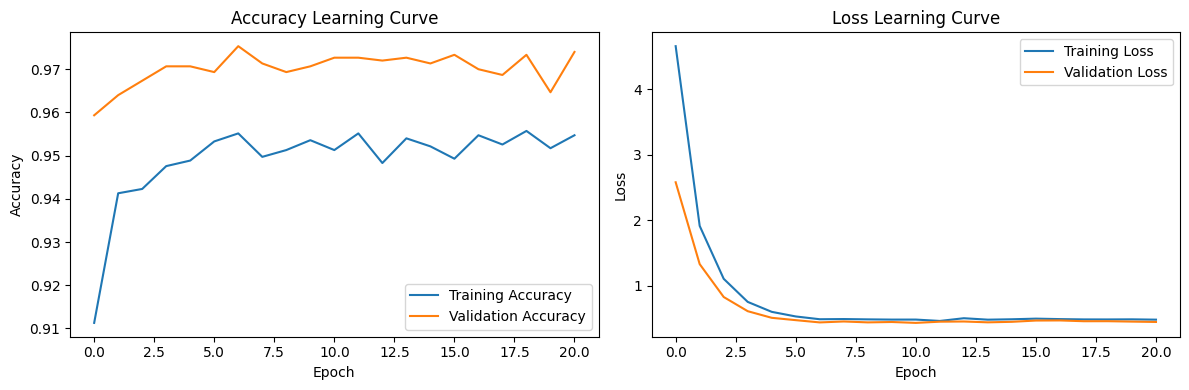

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_accuracy = efficentNet_model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

94/94 [==============================] - 26s 272ms/step - loss: 0.4258 - accuracy: 0.9753
Test Accuracy: 97.53%


In [8]:
predictions = efficentNet_model.predict(test_gen)
true_labels = test_gen.classes
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

94/94 [==============================] - 26s 256ms/step
Confusion Matrix:
[[720  30]
 [  7 743]]

Classification Report:
                  precision    recall  f1-score   support

   breast_benign       0.99      0.96      0.97       750
breast_malignant       0.96      0.99      0.98       750

        accuracy                           0.98      1500
       macro avg       0.98      0.98      0.98      1500
    weighted avg       0.98      0.98      0.98      1500



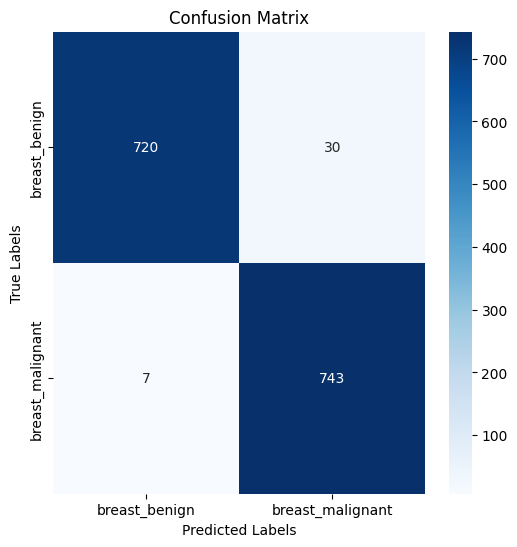

In [9]:
import seaborn as sns
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)

94/94 [==============================] - 23s 244ms/step


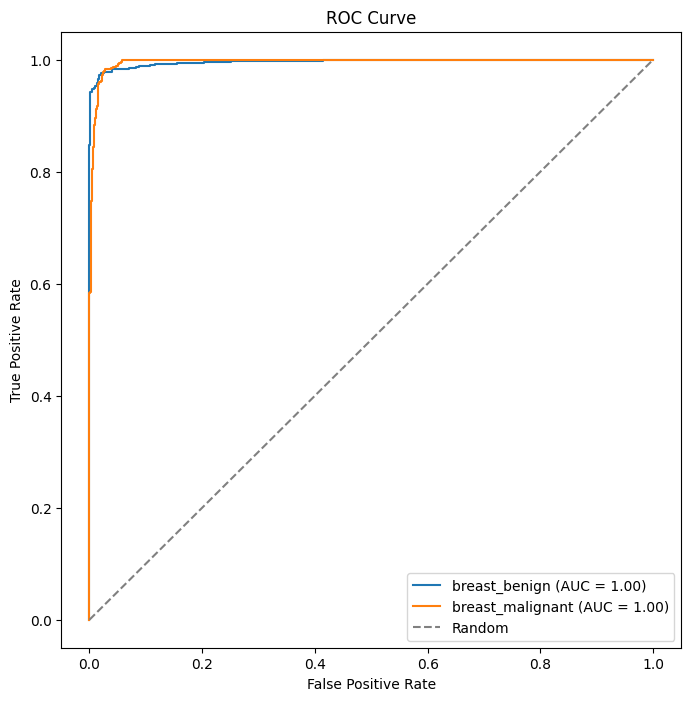

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, class_labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

y_prob = efficentNet_model.predict(test_gen)
y_true = test_gen.classes

y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

plot_roc_curve(y_true_one_hot, y_prob, class_names)